In [1]:
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split  
import matplotlib.pyplot as plt

def evaluate(loader, model):
  model.eval()
  loss_fn = torch.nn.CrossEntropyLoss()
  with torch.no_grad():
    valid_loss = 0
    y_pred  = []
    targets = []
    for input_batch, target_batch in loader:
        logits = model(input_batch)
        loss_val = loss_fn(logits, target_batch)
        valid_loss +=  loss_val.item()
        yp = torch.argmax(F.softmax(logits,dim=1),dim=1)
        y_pred = np.append(y_pred, yp)
        targets = np.append(targets, target_batch.numpy())
    valid_loss /= len(loader)
    tp = np.logical_and((y_pred == 1), (targets == 1)).sum()
    tn = np.logical_and((y_pred == 0), (targets == 0)).sum()
    fn = np.logical_and((y_pred == 0), (targets == 1)).sum()
    fp = np.logical_and((y_pred == 1), (targets == 0)).sum()
    acc = (tp+tn)/(tp+tn+fp+fn)
    precission = tp/(tp+fp)
    recall = tp/(tp+fn)
    f = 2*(precission*recall)/(precission+recall)
    d = {"loss" : valid_loss, 
         "accuracy" : acc.item(),
         "precission" : precission.item(),
         "recall" : recall.item(),
         "f" : f.item()
    }
    return d

def load_data():
  df = pd.read_csv("data/training_data.csv")
  X = df[["Red", "Green", "Blue", "NIR", "ndvi", "ndwi", "msavi2", "mtvi2", "vari", "tgi"]].to_numpy()
  y = df["Class"].to_numpy()
  return X, y

X,y = load_data()

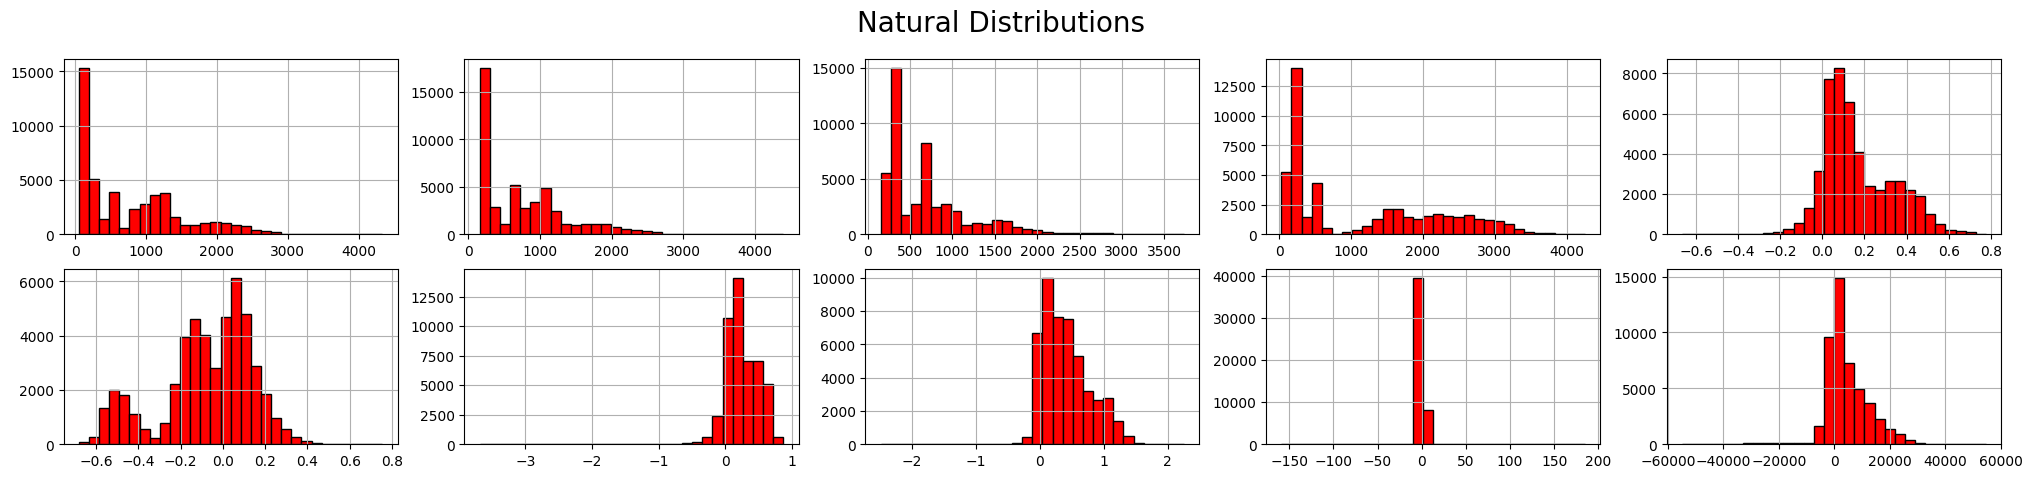

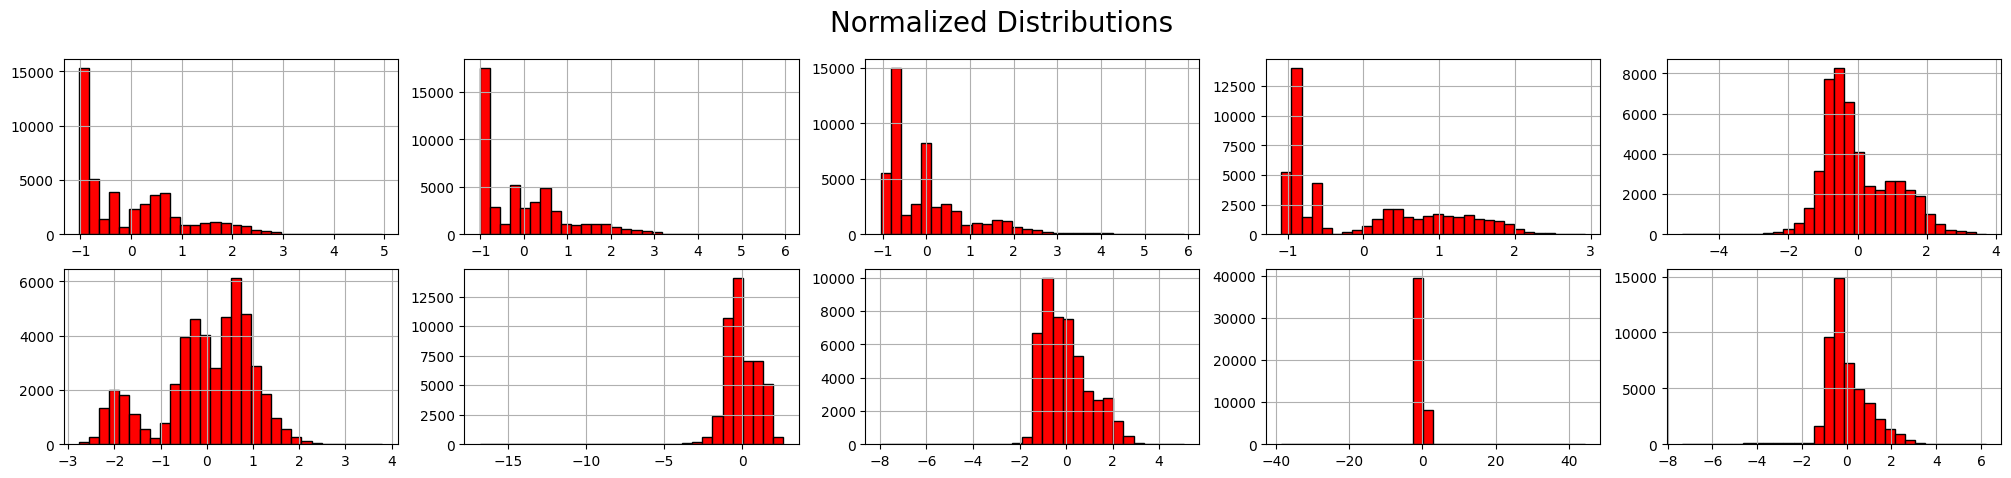

<Figure size 640x480 with 0 Axes>

In [2]:
#plt.hist(X[:,4],bins=30)
def normalize(X):
    N,M = X.shape
    Y = np.zeros([N,M])
    for i in range(M):
        xs = X[:,i]
        xs = (xs - xs.mean()) / xs.std()
        Y[:,i] = xs
    return Y

def vizualize_features(X, title="Normalized Distributions"):
    fig, axes = plt.subplots(2, 5, figsize=(25, 5))
    fig.suptitle(title, fontsize=20)    
    for i in range(2):
        for j in range(5):
            index = j + 5*i
            xs = X[:, index]
            axes[i, j].hist(xs, edgecolor='black', color="red", bins=30)
            axes[i, j].grid(True)
    plt.show()

Y = normalize(X)
vizualize_features(X, "Natural Distributions")
vizualize_features(Y)
plt.subplots_adjust(hspace=0.5)

In [3]:
#X = torch.from_numpy(Y) 
#y = torch.from_numpy(y)
first_batch  = int(len(X)*0.7)
second_batch = len(X) - first_batch
print(f"B1={len(X)}")
print(f"B1={first_batch} B2={second_batch}")

X_train, X_test = X[0:first_batch, :], X[first_batch:, :]
y_train, y_test = y[0:first_batch], y[first_batch:]


X_train, X_test_valid, y_train, y_test_valid = train_test_split(Y, y, test_size=0.4, random_state=42) 
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.2, random_state=42) 
print(f"X_train={len(X_train)}, X_test={len(X_test)}, X_valid={len(X_valid)}")

X_train = torch.from_numpy(X_train) if type(X_train) == np.ndarray else X_train
X_test  = torch.from_numpy(X_test) if type(X_test) == np.ndarray else X_test
X_valid = torch.from_numpy(X_valid) if type(X_valid) == np.ndarray else X_valid

y_train = torch.from_numpy(y_train) if type(y_train) == np.ndarray else y_train
y_test = torch.from_numpy(y_test) if type(y_test) == np.ndarray else y_test
y_valid = torch.from_numpy(y_valid) if type(y_valid) == np.ndarray else y_valid

B1=48142
B1=33699 B2=14443
X_train=28885, X_test=15405, X_valid=3852


# Data Exploration

In [4]:
from collections import Counter 
import pprint

#X_train, X_test_valid, y_train, y_test_valid = train_test_split(Y, y, test_size=0.4, random_state=42) 
cs = Counter(y)
ds = dict(cs)
ds = {int(k): v for k, v in ds.items()}
pprint.pprint(ds)

{0: 6940, 1: 25552, 2: 15650}


#### We are normalizing distribution

In [5]:
class GeoData(Dataset):
    def __init__(self, X, y):
        first_batch  = int(len(X)*0.7)
        self.X_train, self.X_test = X[0:first_batch, :], X[first_batch:, :]
        self.y_train, self.y_test = y[0:first_batch], y[first_batch:]
        self.X_train, self.X_test = torch.tensor(self.X_train), torch.tensor(self.X_test)
        self.y_train, self.y_test = torch.tensor(self.y_train), torch.tensor(self.y_test)

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]
    
class GeoModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 3),
        )

    def param_number(self):
        size = 0
        for ps in self.linear_relu_stack.parameters():
            size += len(ps)
        return size

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

geo_dataset_train  = GeoData(X_train.float(), y_train.long())
geo_dataset_test   = GeoData(X_test.float(), y_test.long())
geo_dataset_valid  = GeoData(X_valid.float(), y_test.long())

model = GeoModel()
train_dl = DataLoader(geo_dataset_train, batch_size=64, shuffle=True)
valid_dl = DataLoader(geo_dataset_valid, batch_size=64, shuffle=True)
test_dl  = DataLoader(geo_dataset_test, batch_size=64, shuffle=True)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 
N = len(train_dl)
train_losses, valid_losses = [], []
loss_fn = torch.nn.CrossEntropyLoss()
EPOCHS = 20
optimizer = optim.SGD(model.parameters(), lr=0.001) 

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for i, (X_batch,y_batch) in enumerate(train_dl):
        model.zero_grad()
        logits = model(X_batch).double()
        loss = loss_fn(logits, y_batch.long())
        loss.backward()
        running_loss += loss
        optimizer.step()
    train_loss = running_loss / N
    valid_loss = evaluate(valid_dl, model)["loss"]
    print(f"epoch={epoch}, train loss = {train_loss}, valid loss = {valid_loss}")
    print("*****")
    train_losses.append(float(running_loss))
    valid_losses.append(float(valid_loss))
    if len(valid_losses) > 3:
        # STOPPING CRITERIA
        if valid_losses[-1] > valid_losses[-2] and valid_losses[-2] > valid_losses[-3]:
            break
    

/tmp/ipykernel_111991/1725718704.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train, self.X_test = torch.tensor(self.X_train), torch.tensor(self.X_test)
/tmp/ipykernel_111991/1725718704.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train, self.y_test = torch.tensor(self.y_train), torch.tensor(self.y_test)


epoch=0, train loss = 1.0959634337345519, valid loss = 1.0824348372082377
*****
epoch=1, train loss = 1.0558532863019805, valid loss = 1.0541420010633247
*****
epoch=2, train loss = 1.0214048063341223, valid loss = 1.034715308699497
*****
epoch=3, train loss = 0.9889958795956697, valid loss = 1.0167722036672193
*****
epoch=4, train loss = 0.9549953640642886, valid loss = 1.0080503613449807
*****
epoch=5, train loss = 0.9143796842568209, valid loss = 0.9987332432769066
*****
epoch=6, train loss = 0.861478530533747, valid loss = 1.0009701931199362
*****
epoch=7, train loss = 0.7904615744594411, valid loss = 1.0175852997358454
*****


In [6]:
def evaluate(loader, model):
  model.eval()
  loss_fn = torch.nn.CrossEntropyLoss()
  with torch.no_grad():
    valid_loss = 0
    y_pred  = []
    targets = []
    for input_batch, target_batch in loader:
        logits = model(input_batch)
        loss_val = loss_fn(logits, target_batch)
        valid_loss +=  loss_val.item()
        yp = torch.argmax(F.softmax(logits,dim=1),dim=1)
        y_pred = np.append(y_pred, yp)
        targets = np.append(targets, target_batch.numpy())
    valid_loss /= len(loader)
    C = confusion_matrix(y_pred, targets)
    return C, y_pred, targets
  
C, yp, targets = evaluate(test_dl, model)
print("************")
print(C)

************
[[   0    0    0]
 [1471 5777 2032]
 [  77    0 1426]]


In [7]:
from collections import Counter 
import pprint
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


def class_counter(y):
    cs = Counter(y)
    ds = dict(cs)
    ds = {int(k): v for k, v in ds.items()}
    pprint.pprint(ds)

X_train, X_test_valid, y_train, y_test_valid = train_test_split(Y, 
                                                                y,
                                                                stratify=y, 
                                                                test_size=0.4, 
                                                                random_state=42) 


class_counter(y_train)
P = float(precision_score(yp, targets, average="weighted"))
R = float(recall_score(yp, targets, average="weighted"))
F = 2/(1/R+1/P)
print(P, R, F)

{0: 4164, 1: 15331, 2: 9390}
0.9180935524595378 0.6679959195029213 0.7733267985268213


/home/doms/miniconda3/envs/geo/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Stratified Learning (Geschichtetes Learning)

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn.functional as F


def stratified_sampling(X, y, class_distrib, strata_size_proba, strata_num):
    classes = {int(y) for y in set(y)}
    N = len(X)
    strata_size = int(N*strata_size_proba)
    stratas = {}
    for i in range(strata_num):
        strata_x, strata_y = [], []
        for c in classes:
            pc = class_distrib[c]
            strata_class_size = int(pc * strata_size)
            y_c_idx = np.where(y == c)[0]  
            sampled_classes_idx = np.random.choice(y_c_idx, size=strata_class_size, replace=False)
            y_c = y[sampled_classes_idx]
            X_c = X[sampled_classes_idx]
            strata_y = np.append(strata_y, y_c)
            strata_x.append( X_c)
        strata_x = np.vstack(strata_x)
        stratas[i] = [strata_x, strata_y]
    samples = list(stratas.values())
    return samples

#stratified_sampling(X, y, [0.333,0.333,0.333], 0.3, 3)
stratas = stratified_sampling(X=X, y=y, class_distrib=[0.333, 0.3333, 0.333], strata_size_proba=0.3, strata_num=10)

In [18]:
import sklearn

def evaluate(loader, model):
  model.eval()
  loss_fn = torch.nn.CrossEntropyLoss()
  with torch.no_grad():
    valid_loss = 0
    y_pred  = []
    targets = []
    for input_batch, target_batch in loader:
        logits = model(input_batch)
        loss_val = loss_fn(logits, target_batch)
        valid_loss +=  loss_val.item()
        yp = torch.argmax(F.softmax(logits,dim=1),dim=1)
        y_pred = np.append(y_pred, yp)
        targets = np.append(targets, target_batch.numpy())
    valid_loss /= len(loader)
    # C = confusion_matrix(y_pred, targets)
    f = sklearn.metrics.f1_score(targets, y_pred, average="weighted")
    return f

def train(model, X, y, epochs=20):
    ###### Dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42) 

    X_train = torch.from_numpy(X_train) if type(X_train) == np.ndarray else X_train
    X_test  = torch.from_numpy(X_test) if type(X_test) == np.ndarray else X_test
    y_train = torch.from_numpy(y_train) if type(y_train) == np.ndarray else y_train
    y_test  = torch.from_numpy(y_test) if type(y_test) == np.ndarray else y_test

    geo_dataset_train  = GeoData(X_train.float(), y_train.long())
    geo_dataset_test   = GeoData(X_test.float(), y_test.long())
    train_dl = DataLoader(geo_dataset_train, batch_size=64, shuffle=True)
    test_dl  = DataLoader(geo_dataset_test, batch_size=64, shuffle=True)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001) 
    N = len(train_dl)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for X_batch,y_batch in train_dl:
            model.zero_grad()
            logits = model(X_batch).double()
            loss = loss_fn(logits, y_batch.long())
            loss.backward()
            running_loss += loss
            optimizer.step()
        train_loss = running_loss / N
        f = evaluate(test_dl, model)
        print(f"epoch={epoch}, train loss = {train_loss}, F = {f}")
        print("*****")
    return model

model = GeoModel()
X,y = load_data()
X = normalize(X)
model = train(model, X, y, epochs=2)

/tmp/ipykernel_111991/1725718704.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train, self.X_test = torch.tensor(self.X_train), torch.tensor(self.X_test)
/tmp/ipykernel_111991/1725718704.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train, self.y_test = torch.tensor(self.y_train), torch.tensor(self.y_test)


epoch=0, train loss = 0.06349921646540893, F = 0.9982935602003427
*****
epoch=1, train loss = 0.003019472246426373, F = 0.9983687281053235
*****


In [19]:
stratas = stratified_sampling(X=X, y=y, class_distrib=[0.333, 0.3333, 0.333], strata_size_proba=0.3, strata_num=10)
models = []
for xs, ys in stratas:
    model = GeoModel()
    m = train(model, xs, ys, epochs=50)
    model.append(m)

/tmp/ipykernel_111991/1725718704.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X_train, self.X_test = torch.tensor(self.X_train), torch.tensor(self.X_test)
/tmp/ipykernel_111991/1725718704.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train, self.y_test = torch.tensor(self.y_train), torch.tensor(self.y_test)


epoch=0, train loss = 0.21482348077927185, F = 0.9972777972692496
*****
epoch=1, train loss = 0.011993375412446779, F = 0.9952917595073812
*****
epoch=2, train loss = 0.00740608345420375, F = 0.9982671423712884
*****
epoch=3, train loss = 0.0049788851221366556, F = 0.9987625969929161
*****
epoch=4, train loss = 0.0038809316339778006, F = 0.999009954283953
*****
epoch=5, train loss = 0.003611947844962707, F = 0.9982675811154403
*****
epoch=6, train loss = 0.0030180084077845518, F = 0.9985147158674463
*****
epoch=7, train loss = 0.004235913390855269, F = 0.9985147158674463
*****
epoch=8, train loss = 0.005907385608159185, F = 0.9992574163371446
*****
epoch=9, train loss = 0.002791915888461036, F = 0.9982671423712884
*****
epoch=10, train loss = 0.004058239868024801, F = 0.9992575149494299
*****
epoch=11, train loss = 0.0032857820833058706, F = 0.9955457341371045
*****
epoch=12, train loss = 0.0036105743115450394, F = 0.9992575149494299
*****
epoch=13, train loss = 0.0023738689042945658, 

AttributeError: 'GeoModel' object has no attribute 'append'

In [27]:
[0]

[array([-0.34239739, -0.09646475, -0.58648601, ..., -0.96964412,
        -0.19036304,  0.96121013]),
 array([0., 0., 0., ..., 2., 2., 2.])]

In [ ]:
stratas